# Machine learning homework7

## 0 Preparation

### 0.1 Import librarys

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cv2 import imread, IMREAD_GRAYSCALE

### 0.2 Read data from files

In [2]:
mnist_x = np.loadtxt('data/mnist_X.csv', delimiter=',')
mnist_y = np.loadtxt('data/mnist_label.csv', delimiter=',')

## 1 Different dimension reduction methods
In this section, we will try different dimension reduction methods, including PCA, LDA, t-SNE and symmetric SNE. At the beginning, I define a utility function which help me to plot the reduction result of a specific method.

In [3]:
def dim_reduce(x, y, method, need_y=False, title=''):
    """Use specific method to reduce dimension to 2 and plot result."""
    x_reduce = method(x, y, reduce_to=2) if need_y else method(x, reduce_to=2)
    fig, ax = plt.subplots()
    fig.suptitle(title)
    ax.scatter(x_reduce[:, 0], x_reduce[:, 1], c=y)
    plt.show()

### 1.1 PCA (Principal Component Analysis)
The step of PCA is as following:
1. Find covariance matrix of input
2. Compute eigen values and eigen vectors of this matrix
3. Sort them by eigen value in descending order, the eigen vector with largest eigen value is the most important principal component
4. Project original data to new space, using the sorted eigen vector $W$   
  $X_{k}=XW_{k}$

In [4]:
def pca(x, reduce_to=2, return_eigen=False):
    """Perform PCA on dataset x, reduce to a certain dimension."""
    # Compute covariance matrix
    x_cov = np.cov(x, rowvar=False)
    # Compute eigen value and eigen vector of convariance
    eigen_val, eigen_vec = np.linalg.eig(x_cov)
    # Sort eigen value and vector according to eigen value in descending order
    eigen_vec = eigen_vec[:, np.argsort(eigen_val)[::-1]]
    eigen_val = eigen_val[np.argsort(eigen_val)[::-1]]
    # Project original data to new space
    result = x @ eigen_vec[:, :reduce_to]
    ret = result.real if not return_eigen else (result.real, (eigen_val, eigen_vec)) 
    return ret

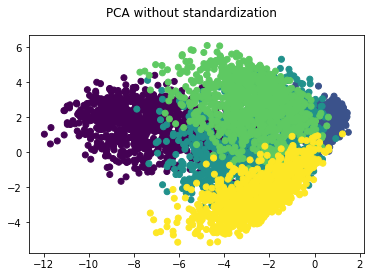

In [5]:
dim_reduce(mnist_x, mnist_y, pca, title='PCA without standardization')

The result of PCA isn't very good. It doesn't show a good partition since defferent label's data point stick together. The reason of this is easy to understand, because PCA aims to find orthogonal project which the data after projection have the maximum variance, it doesn't consider the label of the data points. So this method can make data sparse, but data of different class may not be saparated.

In [6]:
def standardize(x):
    """Standardize x, resulting in zero mean and unit variance."""
    z = np.zeros_like(x)
    std_x = x.std(axis=0)
    std_x_gt0 = std_x > 0
    z[:, std_x_gt0] = (x - x.mean(axis=0))[:, std_x_gt0] / std_x[std_x_gt0]
    return z

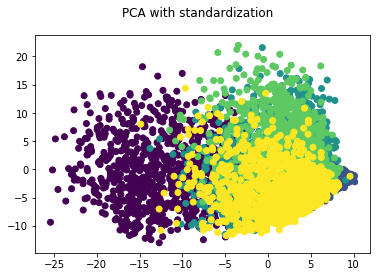

In [7]:
dim_reduce(standardize(mnist_x), mnist_y, pca, title='PCA with standardization')

This is PCA's result too, but the input data is standardize before feeding into the function. The standarization function is $z=\frac{x-\bar{x}}{\sigma}$, which make $x$ has zero mean and unit variance. Compare to the previous result, this is much worser since all data points are much sparse and there are many overlap.

### 1.2 LDA (Linear Discriminant Analysis)
Reference:
- https://sebastianraschka.com/Articles/2014_python_lda.html

The step of LDA is:
1. Find within-class scatter matrix $S_{w}$ and between-class scatter matrix $S_{b}$
  - $S_{w}=\sum_{i=1}^{c}\Sigma{i}$
    - $\Sigma{i}$ is the convariance of class $i$
  - $S_{b}=\sum_{i=1}^{c}N_{i}(m_{i}-m)(m_{i}-m)^T$
    - $N_{i}$ is the number of data points of class $i$
    - $m_{i}$ and $m$ are mean of class $i$ and total mean respectively
2. Compute eigen values and eigen vectors of $S_{w}^{-1}S_{b}$
  - $S_{w}$ may be invertable, we can use pseudo inverse or add a small value to its diagonal to solve the problem
3. Sort them by eigen value in descending order, the eigen vector with largest eigen value is the most important one
4. Project original data to new space, using the sorted eigen vector

In [8]:
def lda(x, y, reduce_to=2, return_eigen=False):
    """Perform LDA on dataset x, reduce to a certain dimension."""
    labels = np.unique(y)
    n_dim = x.shape[1]
    s_w = np.zeros((n_dim, n_dim))
    s_b = np.zeros_like(s_w)
    total_mean = x.mean(axis=0)
    for label in labels:
        mean = x[y==label].mean(axis=0)
        # Compute within-class scatter matrix
        s_w += np.cov(x[y==label], rowvar=False)
        # Compute between-class scatter matrix
        to_total_mean = mean - total_mean
        s_b += (to_total_mean[None, :] * to_total_mean[:, None]) * (y==label).sum()
    # Get eigen value and eigen vector from (s_w)^-1 * s_b
    eigen_val, eigen_vec = np.linalg.eig(np.linalg.pinv(s_w) @ s_b)
    # Sort eigen value and vector according to eigen value in descending order
    eigen_vec = eigen_vec[:, np.argsort(eigen_val)[::-1]]
    eigen_val = eigen_val[np.argsort(eigen_val)[::-1]]
    # Project original data to new space
    result = x @ eigen_vec[:, :reduce_to]
    ret = result.real if not return_eigen else (result.real, (eigen_val, eigen_vec)) 
    return ret

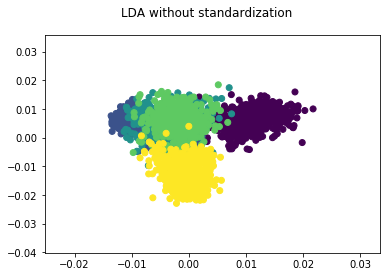

In [9]:
dim_reduce(mnist_x, mnist_y, lda, need_y=True, title='LDA without standardization')

LDA aims to maximize the distance between each class. Although it makes data points of same class crowd enough(compare to PCA), it still cannot saparate different class very well. As we can see, data points on the top left corner have sticked together, even though they belong to different class.

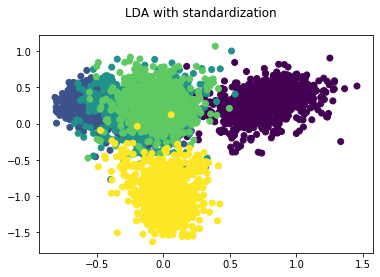

In [10]:
dim_reduce(standardize(mnist_x), mnist_y, lda, need_y=True, title='LDA with standardization')

After standardization, LDA gives a similar result, but with a larger scale.

### 1.3 Symmetric SNE and t-SNE (Stochastic Neighbor Embedding)
Symmetric SNE and t-SNE are very similar thing, the only difference of them is the calculation of pairwise similarities in low-dimensional space(Q), which lead to a slightly difference in objective function and gradient computation.

- Symmetric SNE  
  $q_{ij}=\frac{\exp(-\lVert y_{i}-y_{j}\rVert^2)}{\sum_{k\ne l}\exp(-\lVert y_{k}-y_{l}\rVert^2)}$  
  $\frac{\delta C}{\delta y_{i}}=4\sum_{j}(p_{ij}-q_{ij})(y_{i}-y_{j})$
- T-SNE  
  $q_{ij}=\frac{(1+\lVert y_{i}-y_{j}\rVert^2)^{-1}}{\sum_{k\ne l}(1+\lVert y_{k}-y_{l}\rVert^2)^{-1}}$  
  $\frac{\delta C}{\delta y_{i}}=4\sum_{j}(p_{ij}-q_{ij})(y_{i}-y_{j})(1+\lVert y_{i}-y_{j}\rVert^2)^{-1}$

We use the t-SNE code provided by TA to do t-SNE, and modified its Q and gradient computation to achieve symmetric SNE, also with the visualization of pairwise similarities in low/high dimensional space. On the other hand, I modified the function a little bit to make it fit into my utility function I define before.

In [11]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P

def tsne(X=np.array([]), reduce_to=2, initial_dims=50, perplexity=20.0, symmetric=False):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to reduce_to dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, reduce_to, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(reduce_to, float):
        print("Error: array X should have type float.")
        return -1
    if round(reduce_to) != reduce_to:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, reduce_to)
    dY = np.zeros((n, reduce_to))
    iY = np.zeros((n, reduce_to))
    gains = np.ones((n, reduce_to))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        if symmetric:
            num = np.exp(-np.add(np.add(num, sum_Y).T, sum_Y))
        else:
            num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            if symmetric:
                dY[i, :] = np.sum(np.tile(PQ[:, i], (reduce_to, 1)).T * (Y[i, :] - Y), 0)
            else:
                dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (reduce_to, 1)).T * (Y[i, :] - Y), 0)

        # Perform the updat
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(P, cmap='gray')
    ax[0].set_title('Pairwise similarities in high-dimensional space')
    ax[1].imshow(Q, cmap='gray')
    ax[1].set_title('Pairwise similarities in low-dimensional space')
    plt.show()
    # Return solution
    return Y

Computing pairwise distances...
Computing P-values for point 0 of 5000...
Computing P-values for point 500 of 5000...
Computing P-values for point 1000 of 5000...
Computing P-values for point 1500 of 5000...
Computing P-values for point 2000 of 5000...
Computing P-values for point 2500 of 5000...
Computing P-values for point 3000 of 5000...
Computing P-values for point 3500 of 5000...
Computing P-values for point 4000 of 5000...
Computing P-values for point 4500 of 5000...
Mean value of sigma: 1.799864
Iteration 10: error is 26.586712
Iteration 20: error is 25.212362
Iteration 30: error is 21.379407
Iteration 40: error is 19.534915
Iteration 50: error is 18.778672
Iteration 60: error is 18.434190
Iteration 70: error is 18.243291
Iteration 80: error is 18.099992
Iteration 90: error is 17.991093
Iteration 100: error is 17.915749
Iteration 110: error is 2.780569
Iteration 120: error is 2.616966
Iteration 130: error is 2.483844
Iteration 140: error is 2.370176
Iteration 150: error is 2.271

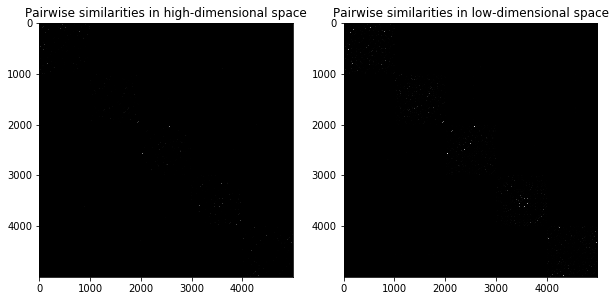

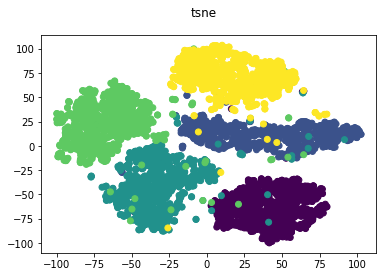

In [12]:
dim_reduce(mnist_x, mnist_y, tsne, title='tsne')

t-SNE's result is much better than the two previous methods. We can easily observe this form the plot above. Each group's data points stay together while keep some distance from other groups. However, the pairwise similarities plot doesn't show a clear result, but we can still see some similarities are kept.

Computing pairwise distances...
Computing P-values for point 0 of 5000...
Computing P-values for point 500 of 5000...
Computing P-values for point 1000 of 5000...
Computing P-values for point 1500 of 5000...
Computing P-values for point 2000 of 5000...
Computing P-values for point 2500 of 5000...
Computing P-values for point 3000 of 5000...
Computing P-values for point 3500 of 5000...
Computing P-values for point 4000 of 5000...
Computing P-values for point 4500 of 5000...
Mean value of sigma: 1.799864
Iteration 10: error is 26.776887
Iteration 20: error is 24.838135
Iteration 30: error is 19.596728
Iteration 40: error is 18.897650
Iteration 50: error is 18.545155
Iteration 60: error is 18.597810
Iteration 70: error is 18.590946
Iteration 80: error is 18.142305
Iteration 90: error is 17.979334
Iteration 100: error is 17.859171
Iteration 110: error is 2.710946
Iteration 120: error is 2.417995
Iteration 130: error is 2.323463
Iteration 140: error is 2.298176
Iteration 150: error is 2.292

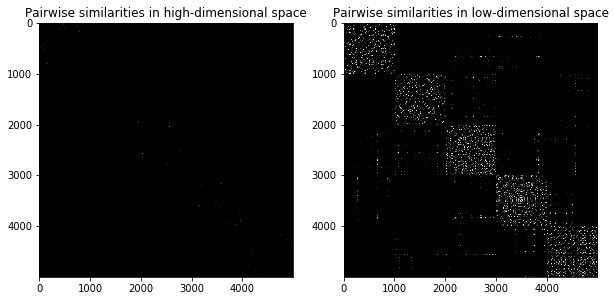

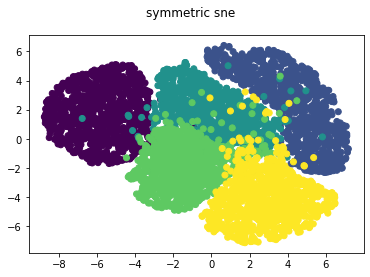

In [13]:
def ssne(X=np.array([]), reduce_to=2, initial_dims=50, perplexity=20.0, symmetric=True):
    """Wrapper function for symmetric SNE."""
    return tsne(X, reduce_to, initial_dims, perplexity, symmetric)
dim_reduce(mnist_x, mnist_y, ssne, title='symmetric sne')

Symmetric SNE has a similar result compare to t-SNE, with a difference that the gap between groups is smaller. Another big difference is that we can see a big change in pairwise similarities in low-dimensional space. There is approximately 5 squares in the graph, representing 5 groups of data, showing that they are similar.

Consequently, t-SNE give the best result in dimension reduction on MNIST data since it group each data well, and saparate each group well.

## 2 Eigen face

### 2.1 Read all images

In [14]:
n_subjects = 40
n_img_per_subject = 10
images = None
for i in range(n_subjects):
    for j in range(n_img_per_subject):
        path = f'data/att_faces/s{i + 1}/{j + 1}.pgm'
        img = imread(path, IMREAD_GRAYSCALE)[None]
        images = img if images is None else np.concatenate((images, img))
n_images, img_h, img_w = images.shape

### 2.2 Define normalization function
Normalize `x` to range of 0 to 1

In [15]:
def normalize(x):
    """Normalize x."""
    x_min = x.min(axis=0)
    x_max = x.max(axis=0)
    z = (x - x_min) / (x_max - x_min)
    return z

### 2.3 Apply PCA to normalized images
First, I define a utility function to convert images(2D) to features(1D), or convert back to images. Then, I apply PCA to normalized features so that they have the same scale. Finally, I get the reduced features and the eigen value/vector back. Here, I reduce those data to 64 dimensions.

In [16]:
def to_images(data, h, w, reverse=False):
    """Convert features to images, or reverse."""
    if reverse:  # Images to feature
        if data.ndim == 2:  # One data
            result = data.reshape(np.prod(data.shape))
        else:  # Multiple data
            result = data.reshape((data.shape[0], np.prod(data.shape[1:])))
    else:  # Features to images
        if data.ndim == 1:  # One data
            result = data.reshape((h, w))
        else:  # Multiple data
            result = data.reshape((data.shape[0], h, w))
    return result
images_x = to_images(images, None, None, reverse=True)

In [17]:
n_pc = 64
images_x_reduced, eigen = pca(normalize(images_x), reduce_to=n_pc, return_eigen=True)

### 2.4 Show eigen face
To show the eigen face, we just need to convert the eigen vectors back to images using the utility function and then plot it.

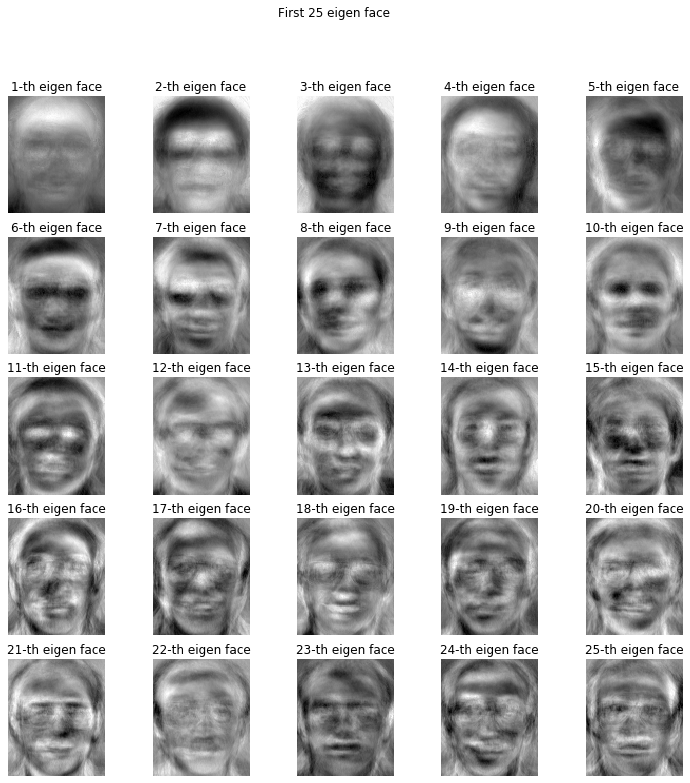

In [18]:
n_eigen_face = 25
n_col = 5
n_row = np.ceil(n_eigen_face / 5).astype(int)
fig, ax = plt.subplots(n_row , n_col, figsize=(n_col * 2.5, n_row * 2.5))
fig.suptitle(f'First {n_eigen_face} eigen face')
for i in range(n_eigen_face):
    row_idx = i // n_col
    col_idx = int(i % n_col)
    img = to_images(eigen[1][:, i].real, img_h, img_w)
    ax[row_idx, col_idx].set_title(f'{i + 1}-th eigen face')
    ax[row_idx, col_idx].imshow(img, cmap='gray')
    ax[row_idx, col_idx].set_axis_off()
plt.show()

The first eigen face is the most important principal component, the second one is the second most and so on. We show the first 25 eigen face here.

### 2.5 Reconstruct faces
To reconstruct from reduced one, we just need to multiply the transpose of eigen vector $W$
$X'=XW_{k}W_{k}^T=X_{k}W_{k}^T$

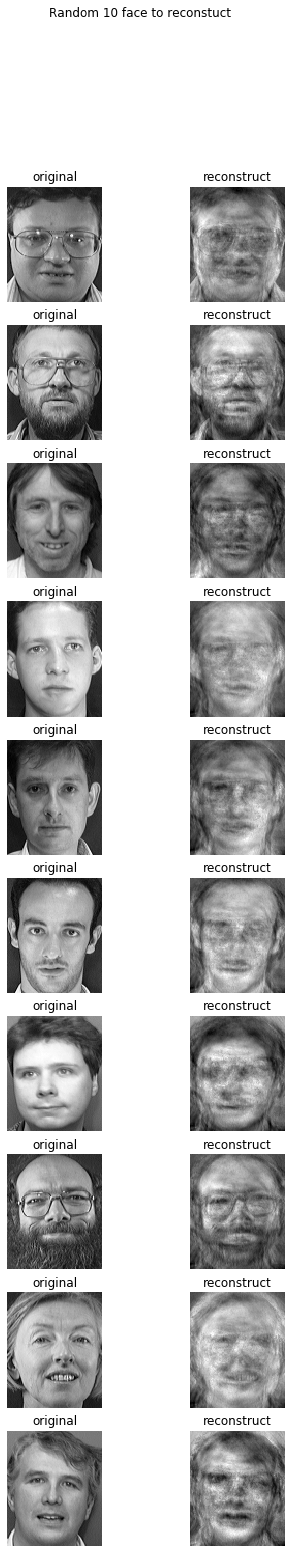

In [19]:
n_reconstruct = 10
reconstruct_idx = np.random.randint(0, n_images, n_reconstruct)
fig, ax = plt.subplots(n_reconstruct , 2, figsize=(6, n_reconstruct * 2.5))
fig.suptitle(f'Random {n_reconstruct} face to reconstuct')
for i in range(n_reconstruct):
    idx = reconstruct_idx[i]
    ax[i, 0].imshow(images[idx], cmap='gray')
    ax[i, 0].set_title('original')
    ax[i, 0].set_axis_off()
    img = (images_x_reduced[idx] @ eigen[1][:, 0:n_pc].T).real
    img = to_images(img, img_h, img_w)
    ax[i, 1].imshow(img, cmap='gray')
    ax[i, 1].set_title('reconstruct')
    ax[i, 1].set_axis_off()
plt.show()

We can see that the reconstructed one lose lots of information, but we can still see the structure of face is similar.